In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import densenet121
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Set the device to use (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Set the path to your dataset
dataset_dir = ""

# Set the input size for resizing the images
input_size = (128,128)

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

In [4]:
# Load the training dataset
train_dataset = ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the test dataset
test_dataset = ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Load the pre-trained DenseNet model
model = densenet121(pretrained=True)
num_classes = len(train_dataset.classes)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

c:\Users\Alvin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alvin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_accuracy = train_correct / len(train_dataset)
    train_loss /= len(train_loader)

    # Evaluation on the test set
    model.eval()
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / len(test_dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f}")


Epoch [1/20] Train Loss: 0.5733 Train Accuracy: 0.7895 Test Accuracy: 0.8329
Epoch [2/20] Train Loss: 0.2640 Train Accuracy: 0.9103 Test Accuracy: 0.7125
Epoch [3/20] Train Loss: 0.1201 Train Accuracy: 0.9629 Test Accuracy: 0.9511
Epoch [4/20] Train Loss: 0.0653 Train Accuracy: 0.9819 Test Accuracy: 0.7784
Epoch [5/20] Train Loss: 0.0622 Train Accuracy: 0.9852 Test Accuracy: 0.9185
Epoch [6/20] Train Loss: 0.1698 Train Accuracy: 0.9429 Test Accuracy: 0.8544
Epoch [7/20] Train Loss: 0.0635 Train Accuracy: 0.9796 Test Accuracy: 0.9744
Epoch [8/20] Train Loss: 0.0221 Train Accuracy: 0.9964 Test Accuracy: 0.9755
Epoch [9/20] Train Loss: 0.0929 Train Accuracy: 0.9672 Test Accuracy: 0.9796
Epoch [10/20] Train Loss: 0.0443 Train Accuracy: 0.9892 Test Accuracy: 0.9681
Epoch [11/20] Train Loss: 0.0875 Train Accuracy: 0.9773 Test Accuracy: 0.9596
Epoch [12/20] Train Loss: 0.0273 Train Accuracy: 0.9938 Test Accuracy: 0.9785
Epoch [13/20] Train Loss: 0.0436 Train Accuracy: 0.9878 Test Accuracy: 0.

In [8]:
# Uncomment below lines to save model
# # Path for the saved model
path = './models/densenet.pt'
# Comment out below line if you have already saved model and just want to retrieve it (not saving)
# torch.save(model.state_dict(), path)

In [9]:
# Calculate the final accuracy on the entire test dataset
model.load_state_dict(torch.load(path))
model.eval()
test_correct = 0

preds_tensor = torch.Tensor()
labels_tensor = torch.Tensor()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        preds_tensor = torch.cat((preds_tensor, predicted))
        labels_tensor = torch.cat((labels_tensor, labels))
        test_correct += (predicted == labels).sum().item()

final_test_accuracy = test_correct / len(test_dataset)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")


Final Test Accuracy: 0.9889


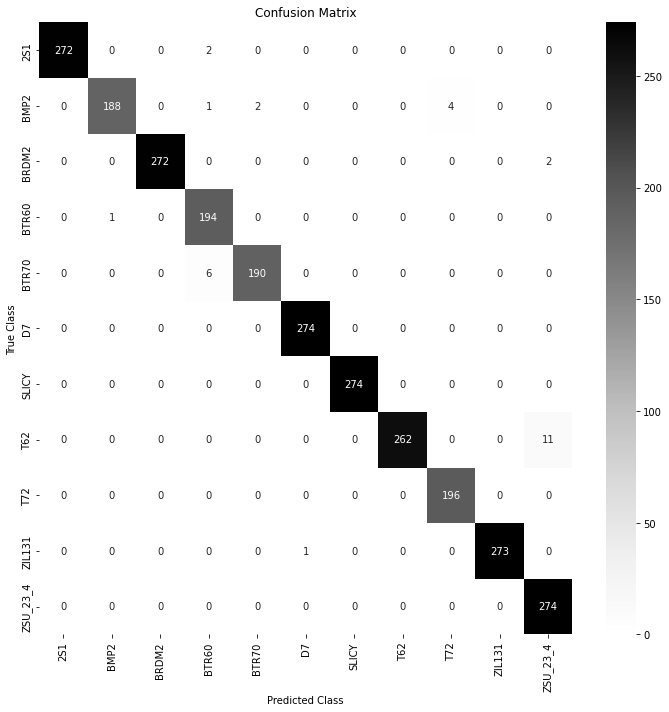

In [18]:
preds = preds_tensor.numpy()
actual = labels_tensor.numpy()

# Define the mapping dictionary
class_mapping = {
    0: '2S1',
    1: 'BMP2',
    2: 'BRDM2',
    3: 'BTR60',
    4: 'BTR70',
    5: 'D7',
    6: 'SLICY',
    7: 'T62',
    8: 'T72',
    9: 'ZIL131',
    10: 'ZSU_23_4'
}

y_preds = np.array([class_mapping[value] for value in preds])
y_true = np.array([class_mapping[value] for value in actual])

class_labels = ['2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70',
                'D7', 'SLICY', 'T62', 'T72', 'ZIL131', 'ZSU_23_4']

# Create the confusion matrix
cm = confusion_matrix(y_true, y_preds, labels=class_labels)

# Set figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Create the heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Configure figure properties
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()

# Show the figure
plt.show()


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

classification_report(y_true, y_preds, labels=class_labels, output_dict=True)

{'2S1': {'precision': 1.0,
  'recall': 0.9927007299270073,
  'f1-score': 0.9963369963369962,
  'support': 274},
 'BMP2': {'precision': 0.9947089947089947,
  'recall': 0.9641025641025641,
  'f1-score': 0.9791666666666667,
  'support': 195},
 'BRDM2': {'precision': 1.0,
  'recall': 0.9927007299270073,
  'f1-score': 0.9963369963369962,
  'support': 274},
 'BTR60': {'precision': 0.9556650246305419,
  'recall': 0.9948717948717949,
  'f1-score': 0.9748743718592966,
  'support': 195},
 'BTR70': {'precision': 0.9895833333333334,
  'recall': 0.9693877551020408,
  'f1-score': 0.9793814432989691,
  'support': 196},
 'D7': {'precision': 0.9963636363636363,
  'recall': 1.0,
  'f1-score': 0.9981785063752276,
  'support': 274},
 'SLICY': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 274},
 'T62': {'precision': 1.0,
  'recall': 0.9597069597069597,
  'f1-score': 0.9794392523364486,
  'support': 273},
 'T72': {'precision': 0.98,
  'recall': 1.0,
  'f1-score': 0.98989898989899,
  'support

In [36]:
matrix = confusion_matrix(y_true, y_preds, labels=class_labels)
class_wise_accuracies = matrix.diagonal()/matrix.sum(axis=1)

#Display the class-wise accuracies
for i, accuracy in enumerate(class_wise_accuracies):
    label = class_labels[i]
    print(f'Accuracy of class {label}: {accuracy:.2%}')


Accuracy of class 2S1: 99.27%
Accuracy of class BMP2: 96.41%
Accuracy of class BRDM2: 99.27%
Accuracy of class BTR60: 99.49%
Accuracy of class BTR70: 96.94%
Accuracy of class D7: 100.00%
Accuracy of class SLICY: 100.00%
Accuracy of class T62: 95.97%
Accuracy of class T72: 100.00%
Accuracy of class ZIL131: 99.64%
Accuracy of class ZSU_23_4: 100.00%


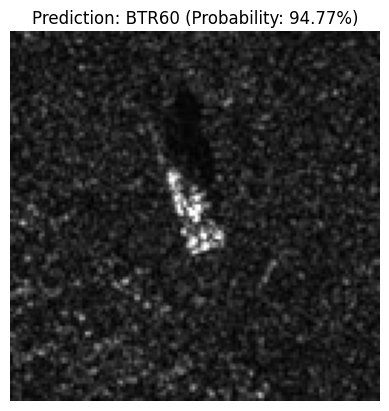

2S1: 0.04%
BMP2: 0.95%
BRDM2: 0.22%
BTR60: 94.77%
BTR70: 0.40%
D7: 0.75%
SLICY: 0.00%
T62: 0.12%
T72: 0.04%
ZIL131: 2.66%
ZSU_23_4: 0.06%


In [15]:
import numpy as np
from PIL import Image


# Prediction on a single image
def predict_single_image(image, model, device, transform, class_names):
    model.eval()

    if isinstance(image, str):  # If image is a file path, load it using PIL
        image = Image.open(image)

    # If the image has only one channel, convert it to RGB
    if image.mode == 'L':
        image = image.convert('RGB')

    # Resize the image to the desired input size
    image = image.resize((128, 128))

    # Convert the image to a NumPy array and normalize the values
    image = np.array(image, dtype=np.float32) / 255.0

    # Convert the NumPy array to a PyTorch tensor
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)
        probability = torch.softmax(output, dim=1)[0] * 100

    class_name = class_names[predicted_class.item()]
    probability_percent = probability[predicted_class.item()].item()

    # Get probabilities for all classes
    all_probabilities = probability.cpu().numpy()

    # Create a dictionary to store class probabilities
    class_probabilities = {class_names[i]: prob.item() for i, prob in enumerate(all_probabilities)}

    plt.imshow(np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0)))
    plt.title(f"Prediction: {class_name} (Probability: {probability_percent:.2f}%)")
    plt.axis('off')
    plt.show()

    return class_probabilities

# Get prediction for a user-input image
user_input_image = "test/2S1/HB14945.jpeg"  # Replace with the actual file name of the image
class_probabilities = predict_single_image(user_input_image, model, device, transform, class_names)

# Print probabilities of all classes
for class_name, probability in class_probabilities.items():
    print(f"{class_name}: {probability:.2f}%")
